In [1]:
import os
import mat73
import torch
import pickle
import numpy as np
import nibabel as nib
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting

/Users/xli77/miniconda3/envs/nhpseg/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pyfile = "recovered_sources/res_mmiva_W_lr0.0001.p"
with open(pyfile, 'rb') as handle:
    res = pickle.load(handle)

source_py = res['recovered_sources']

source_mat = mat73.loadmat("recovered_sources/data1_Y.mat")['Y']

source_py_smri = source_py[0]
source_py_fmri = source_py[1]
source_py_dmri = source_py[2]

source_mat_smri = source_mat[0]
source_mat_fmri = source_mat[1]
source_mat_dmri = source_mat[2]

In [4]:
Xpath="/Users/xli77/Documents/MISA/MISA-data/sMRI-fMRI-DTI/X.mat"
X=mat73.loadmat(Xpath)['X']
X=np.squeeze(X)

/Users/xli77/miniconda3/envs/nhpseg/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [7]:
maskpath="/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/wmMask_TPM_thrp4_fractc8_3mm.nii"
maskfile=nib.load(maskpath)
mask=maskfile.get_fdata()
# sio.savemat("/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/mask/wmMask_TPM_thrp4_fractc8_3mm.mat", {"mask":mask})

In [14]:
Y = source_py_smri.T
At = np.linalg.inv(Y @ Y.T) @ (Y @ X[0].T)
A = At.T

sio.savemat("recovered_sources/A_sMRI_python.mat", {"A":A})

Y = source_py_fmri.T
At = np.linalg.inv(Y @ Y.T) @ (Y @ X[1].T)
A = At.T

sio.savemat("recovered_sources/A_fMRI_python.mat", {"A":A})

Y = source_py_dmri.T
At = np.linalg.inv(Y @ Y.T) @ (Y @ X[2].T)
A = At.T

sio.savemat("recovered_sources/A_dMRI_python.mat", {"A":A})

In [16]:
Y = source_mat_smri
At = np.linalg.inv(Y @ Y.T) @ (Y @ X[0].T)
A = At.T

sio.savemat("recovered_sources/A_sMRI_matlab.mat", {"A":A})

Y = source_mat_fmri
At = np.linalg.inv(Y @ Y.T) @ (Y @ X[1].T)
A = At.T

sio.savemat("recovered_sources/A_fMRI_matlab.mat", {"A":A})

Y = source_mat_dmri
At = np.linalg.inv(Y @ Y.T) @ (Y @ X[2].T)
A = At.T

sio.savemat("recovered_sources/A_dMRI_matlab.mat", {"A":A})

In [24]:
for mri in ['sMRI', 'fMRI', 'dMRI']:
    for code in ['python', 'matlab']:
        vol = sio.loadmat(f"recovered_sources/vol3d_{mri}_{code}.mat")['vol3d']
        for i in range(30):
            fig, ax = plt.subplots(1,1,figsize=(8,3))
            img = nib.Nifti1Image(vol[i],maskfile.affine)
            plotting.plot_glass_brain(img,title=f"$SCV{i+1}$",colorbar=True,cbar_tick_format='%.3f',alpha=0.7,axes=ax)#axes=axes[i],
            fig.savefig(f'glass_brain/{mri}_{code}_SCV{i+1}.pdf', bbox_inches = 'tight', pad_inches = 0)

In [26]:
for mri in ['sMRI', 'fMRI', 'dMRI']:
    for code in ['python', 'matlab']:
        vol = sio.loadmat(f"recovered_sources/vol3d_{mri}_{code}.mat")['vol3d']
        for i in range(30):
            fig, ax = plt.subplots(1,1,figsize=(8,3))
            img = nib.Nifti1Image(vol[i],maskfile.affine)
            plotting.plot_stat_map(img,title=f"$SCV{i+1}$",colorbar=True,cbar_tick_format='%.3f',axes=ax)            
            fig.savefig(f'stat_map/{mri}_{code}_SCV{i+1}.pdf', bbox_inches = 'tight', pad_inches = 0)

In [18]:
vol_list = []
for mri in ['sMRI', 'fMRI', 'dMRI']:
    for code in ['python', 'matlab']:
        vol = sio.loadmat(f"recovered_sources/vol3d_{mri}_{code}.mat")['vol3d']
        if code == 'python':
            vol_list.append(-vol[1])
        else:
            vol_list.append(vol[7])

/Users/xli77/miniconda3/envs/nhpseg/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


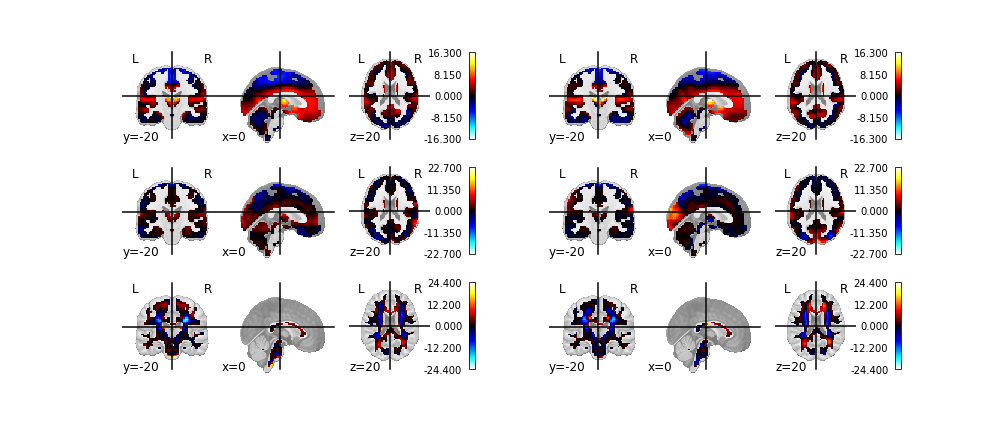

In [31]:
# same slice
# divide scv by std, scale colormap to be the same for each row
num_rows = 3
num_cols = 2
scv_list = [2, 8]
cmmax = [16.3,22.7,24.4]
fig, axes = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=(14,6))

for i, mri in enumerate(['sMRI', 'fMRI', 'dMRI']):
    for j, code in enumerate(['PyTorch', 'MATLAB']):
        scv = vol_list[2*i+j]
        scv_std = scv / np.std(scv)
        img = nib.Nifti1Image(scv_std,maskfile.affine)
        plotting.plot_stat_map(img,colorbar=True,cbar_tick_format='%.3f',cut_coords=(0,-20,20),vmax=cmmax[i],axes=axes[i,j])
# title=f"{mri} {code} SCV{scv_list[j]}",threshold=np.max(vol)*0.2,
plt.tight_layout()
fig.savefig('stat_map.pdf', bbox_inches = 'tight', pad_inches = 0)
# fig.savefig('stat_map_wlabel.pdf', bbox_inches = 'tight', pad_inches = 0)